# Exploratory Statistics - Variant Quality

This comes from the example notebook and the [tour of scikit-allel](http://alimanfoo.github.io/2016/06/10/scikit-allel-tour.html) blog post.

Now we're going to look at the variant quality. Depending on the steps you've taken before hand, such as filtering with snpeff, you may or may not find anything very interesting.

In [14]:
import numpy as np
import zarr
import pandas as pd
import dask.array as da
import allel
import scipy
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
%matplotlib inline

In [2]:
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=30)
cluster

distributed.scheduler - INFO - Clear task state
/opt/conda/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
distributed.scheduler - INFO -   Scheduler at:   tcp://10.35.63.92:46345
distributed.scheduler - INFO -   dashboard at:                    :39477


## Import the Variant Data

In [4]:
import gcsfs

gcs_bucket_fs = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='anon', access='read_only')

storage_path = 'ag1000g-release/phase2.AR1/variation/main/zarr/pass/ag1000g.phase2.ar1.pass'
store = gcsfs.mapping.GCSMap(storage_path, gcs=gcs_bucket_fs, check=False, create=False)
callset = zarr.Group(store)

distributed.scheduler - INFO - Register tcp://10.35.50.2:44315
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.50.2:44315
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.35.62.2:43395
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.62.2:43395
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.35.46.2:39961
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.46.2:39961
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.35.47.2:40313
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.47.2:40313
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.35.64.2:38827
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.64.2:38827
distributed.core - INFO

In [6]:
chrom = '3L'
variants = allel.VariantChunkedTable(callset[chrom]['variants'], 
                                     names=['POS', 'REF', 'ALT', 'DP', 'MQ', 'QD'],
                                     index='POS')
variants

<VariantChunkedTable shape=(10640388,) dtype=[('POS', '<i4'), ('REF', 'S1'), ('ALT', 'S1', (3,)), ('DP', '<i4'), ('MQ', '<f4'), ('QD', '<f4')]
   nbytes=202.9M cbytes=-6 cratio=-35467960.0
   values=zarr.hierarchy.Group>

## Investigate variant quality

The DP, MQ and QD attributes are potentially informative about SNP quality. For example, we have a prior expectation that putative SNPs with very high or very low DP may coincide with some form of larger structural variation, and may therefore be unreliable. However, it would be great to have some empirical indicator of data quality, which could guide our choices about how to filter the data.

There are several possible quality indicators that could be used, and in general it’s a good idea to use more than one if available. Here, to illustrate the general idea, let’s use just one indicator, which is the number of transitions divided by the number of transversions, which I will call Ti/Tv.

![Chemicals](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/Transitions-transversions-v4.svg/500px-Transitions-transversions-v4.svg.png)

If mutations were completely random we would expect a Ti/Tv of 0.5, because there are twice as many possible transversions as transitions. However, in most species a mutation bias has been found towards transitions, and so we expect the true Ti/Tv to be higher. We can therefore look for features of the raw data that are associated with low Ti/Tv (close to 0.5) and be fairly confident that these contain a lot of noise.

To do this, let’s first set up an array of mutations, where each entry contains two characters representing the reference and alternate allele. For simplicity of presentation I’m going to ignore the fact that some SNPs are multiallelic, but if doing this for real this should be restricted to biallelic variants only.

In [7]:
mutations = np.char.add(variants['REF'], variants['ALT'][:, 0])
mutations

array([b'CT', b'GT', b'GA', ..., b'CA', b'GA', b'TA'], dtype='|S2')

In [8]:
def locate_transitions(x):
    """Define a function to locate transition mutations within a mutations array."""
    x = np.asarray(x)
    return (x == b'AG') | (x == b'GA') | (x == b'CT') | (x == b'TC')

Demonstrate how the locate_transitions function generates a boolean array from a mutations array.

In [9]:
is_ti = locate_transitions(mutations)
is_ti

array([ True, False,  True, ..., False,  True, False])

Define a function to compute Ti/Tv.

In [10]:
def ti_tv(x):
    if len(x) == 0:
        return np.nan
    is_ti = locate_transitions(x)
    n_ti = np.count_nonzero(is_ti)
    n_tv = np.count_nonzero(~is_ti)
    if n_tv > 0:
        return n_ti / n_tv
    else:
        return np.nan

Demonstrate the ti_tv function by computing Ti/Tv over all SNPs.

In [11]:
ti_tv(mutations)

1.1344549244231916

Define a function to plot Ti/Tv in relation to a variant attribute like DP or MQ.

In [23]:
# WIP this function doesn't quite work as is

def plot_ti_tv(f, downsample, bins):
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.despine(ax=ax, offset=10)
    x = variants[f][:][::downsample]
    
    # plot a histogram
    ax.hist(x, bins=bins)
    ax.set_xlabel(f)
    ax.set_ylabel('No. variants')

    # plot Ti/Tv
    ax = ax.twinx()
    sns.despine(ax=ax, bottom=True, left=True, right=False, offset=10)
    values = mutations[::downsample]
    with np.errstate(over='ignore'):
        # binned_statistic generates an annoying overflow warning which we can ignore
        y1, _, _ = scipy.stats.binned_statistic(x, values, statistic=ti_tv, bins=bins)
    bx = (bins[1:] + bins[:-1]) / 2
    ax.plot(bx, y1, color='k')
    ax.set_ylabel('Ti/Tv')
    ax.set_ylim(0.6, 1.3)

    ax.set_title('Variant %s and Ti/Tv' % f)

Example the relationship between the QD, MQ and DP attributes and Ti/Tv.

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

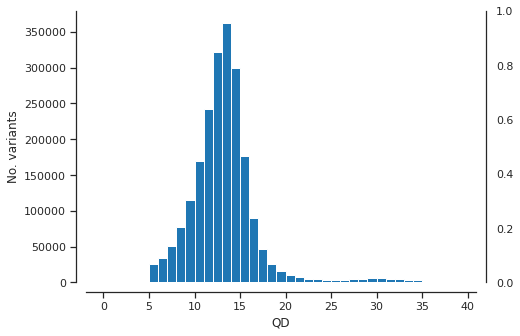

In [20]:
plot_ti_tv('QD', downsample=5, bins=np.arange(0, 40, 1))

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

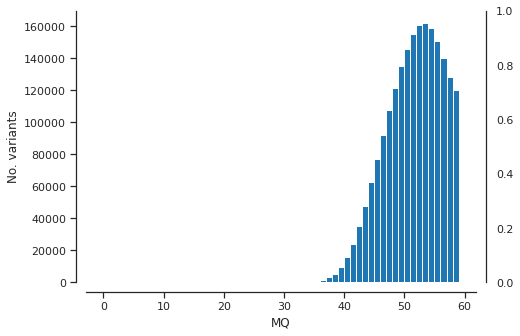

In [21]:
plot_ti_tv('MQ', downsample=5, bins=np.arange(0, 60, 1))

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

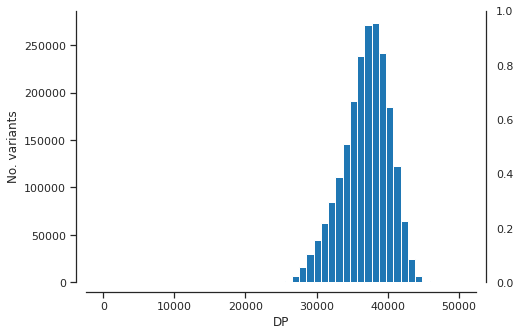

In [24]:
plot_ti_tv('DP', downsample=5, bins=np.linspace(0, 50000, 50))

Ti/Tv is not a simple variable and so some care is required when interpreting these plots. However, we can see that there is a trend towards low Ti/Tv for low values of QD, MQ and DP.

To investigate further, let’s look at Ti/Tv in two dimensions.

In [25]:
def plot_joint_ti_tv(f1, f2, downsample, gridsize=20, mincnt=20, vmin=0.6, vmax=1.4, extent=None):
    fig, ax = plt.subplots()
    sns.despine(ax=ax, offset=10)
    x = variants[f1][:][::downsample]
    y = variants[f2][:][::downsample]
    C = mutations[::downsample]
    im = ax.hexbin(x, y, C=C, reduce_C_function=ti_tv, mincnt=mincnt, extent=extent,
                   gridsize=gridsize, cmap='jet', vmin=vmin, vmax=vmax)
    fig.colorbar(im)
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_title('Variant %s versus %s and Ti/Tv' % (f1, f2))

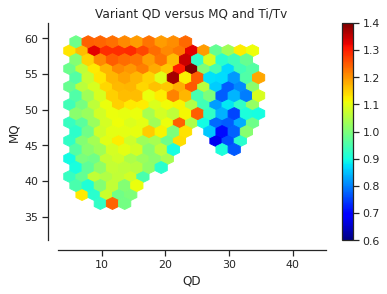

In [26]:
plot_joint_ti_tv('QD', 'MQ', downsample=5, mincnt=400)

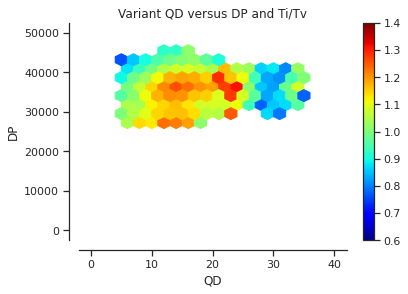

In [27]:
plot_joint_ti_tv('QD', 'DP', downsample=5, mincnt=400, extent=(0, 40, 0, 50000))

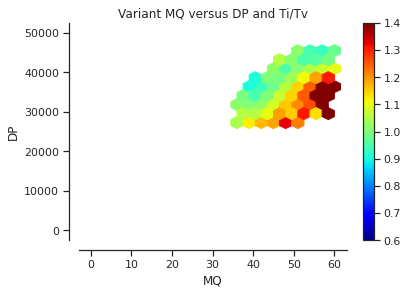

distributed.utils_perf - INFO - full garbage collection released 127.55 MB from 35241 reference cycles (threshold: 10.00 MB)
distributed.scheduler - INFO - Remove worker tcp://10.35.47.2:40313
distributed.core - INFO - Removing comms to tcp://10.35.47.2:40313


In [28]:
plot_joint_ti_tv('MQ', 'DP', downsample=5, mincnt=400, extent=(0, 60, 0, 50000))

This information may be useful when designing a variant filtering strategy. If you have other data that could be used as a quality indicator, such as Mendelian errors in a trio or cross, and/or data on genotype discordances between replicate samples, a similar analysis could be performed.